In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest 
import matplotlib.pyplot as plt
import itertools

from tqdm.auto import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width',1000)


#### Описание задания

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана
Описание колонок

    experimentVariant – вариант эксперимента
    version – версия приложения
    purchase – факт покупки

Задача

    Запустите A/A-тест
    Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
    Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
    Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [2]:
hw=pd.read_csv('hw_aa.csv', sep = ';')
hw.head()
#df.info()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [ ]:
Будем сравнивать метрику(она у нас одна), а именно  purchase (факт совершения покупки)
между вариантами эксперимента experimentVariant и version (версиями) 

#### Создаем функцию metric_fpr котрая будет считать fpr с помощью АА тестирования.
#### df_x - значения для варианта 1, 
#### df_y - значения для варианта 2, 
#### metric_col - целевая метрика для проверки в данном случае это purchase, 
#### n_sim - количество симуляций, 
#### n_s_perc - % наблюдений от исходной которое мы будем брать для подвыборок, 
#### n_s_min - граница наблюдений выше которой мы не будем брать, 
#### estimator - оценщик, 
#### *arqs, **kwarqs - аргументы для оценщика

In [6]:
def metric_fpr (df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *arqs, **kwarqs):
    stat_res = {'aa':{'pvalue': [], 'mu_x': [], 'mu_y': []}, 'fpr': {'fpr_95': 0}}
    # Берем [metric_col] - % значений  от исходной выборки, но не более n_s_min
    for sim in range(n_sim):
        x=df_x[metric_col].sample(int(min(n_s_min, len(df_x)*n_s_perc)), replace = False).values
        y=df_y[metric_col].sample(int(min(n_s_min, len(df_y)*n_s_perc)), replace = False).values
        
        # Используем 1 оценщик proportions_ztest и оценщик 2 ttest
        if estimator =='prop':
            counts = np.array ([sum(x), sum(y)])
            nobs = np.array ([len(x), len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *arqs, **kwarqs)
            
        if estimator =='ttest':
            stat, pvalue = stats.ttest_ind(x, y, *arqs, **kwarqs)
            
        # Будем записывать pvalueсреднее значенние по X и Y   
        stat_res['aa']['pvalue'].append (pvalue)
        stat_res['aa']['mu_x'].append (np.mean(x))
        stat_res['aa']['mu_y'].append (np.mean(y))
        
    # На выходе проверяем уровень значимости     
    stat_res['fpr']['fpr_95'] = float(sum(np.array(stat_res['aa']['pvalue'])<=0.05)/n_sim)
    return stat_res
     


#### Вторая функция будет использовать первую и будет проходить по всем группам (в данном случае это версии продукта)
#### и там будем искать разницу между среднимими их значениями

In [9]:
def fpr_report (df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *arqs, **kwarqs):
    list_fpr = []
    list_group = list(pd.unique(df[group_col]))
    
    for v in range (len(list_group)):
        df_x = df[(df[variant_col]==0)&(df[group_col]==list_group[v])]
        df_y = df[(df[variant_col]==1)&(df[group_col]==list_group[v])]
        cr_x = sum (df_x[metric])/len(df_x)
        cr_y = sum (df_x[metric])/len(df_y)
        
        fpr = {}
        fpr = metric_fpr (df_x=df_x, df_y = df_y, metric_col = metric, n_sim = n_sim, n_s_perc = n_s_perc, n_s_min=n_s_min, estimator=estimator, *arqs, **kwarqs)
        is_fpr = (fpr['fpr']['fpr_95']<=0.05)
        list_fpr.append ([list_group[v], cr_x, cr_y, fpr['fpr']['fpr_95'],is_fpr ])
        
    report = pd.DataFrame.from_records(list_fpr, columns = ['group', 'cr_x', 'cr_y', 'fpr_95', 'is_fpr' ])
    return report

In [10]:
n_sim  = 1000
n_s_perc =0.9 # Подвыборки берем 90% от исходной
n_s_min = 1000 # Количество итераций
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res=fpr_report(df=hw, metric_col = metric, variant_col =variant, group_col=group, n_sim = n_sim, n_s_perc=n_s_perc, n_s_min=n_s_min, estimator='ttest' )
res


,group,cr_x,cr_y,fpr_95,is_fpr
0,v2.8.0,0.000993,0.000987,1.000,False
1,v2.9.0,0.074658,0.073963,0.051,False
2,v3.7.4.0,0.059943,0.059701,0.033,True
3,v3.8.0.0,0.057604,0.053682,0.065,False


In [ ]:
Из указанного выше тестирования видно что 3.7.4.0 AA тест прошла, 2.8.0 абсолютно поломана значение равно 1,
версии 2.9.0 и 3.8.0.0 близки к норме, но надо прогнать еще и посмотреть, а так ли это на самом деле и не будет ли более серьзный разрыв от нормы 


FPR = 1.0


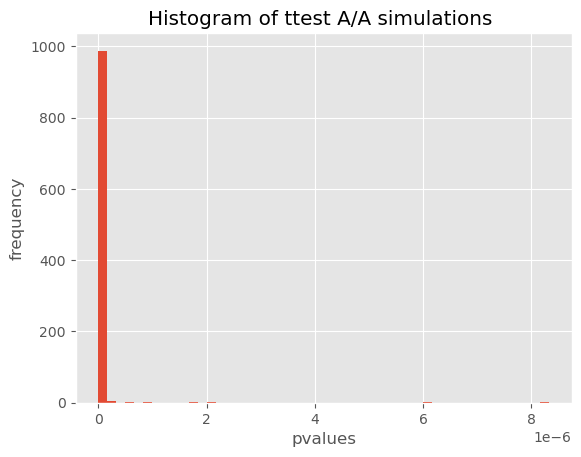

In [22]:
res = metric_fpr( hw[( hw['experimentVariant']==0)&( hw['version']=='v2.8.0')],  hw[( hw['experimentVariant']==1)&( hw['version']=='v2.8.0')], metric_col = metric, n_sim = 1000, n_s_perc = n_s_perc, n_s_min = n_s_min, estimator = 'prop')
# так же при необходимости estimator = stats.ttest_ind

print ('FPR = {}'.format (res['fpr']['fpr_95']))

plt.hist(res['aa']['pvalue'], bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()


In [ ]:
Да действительно сравнив версию 2.8.0 ложноположительных оценок меньше альфа, равно 100%

In [ ]:
На примере ниже, мы исключили версию 2.8.0

FPR = 0.044


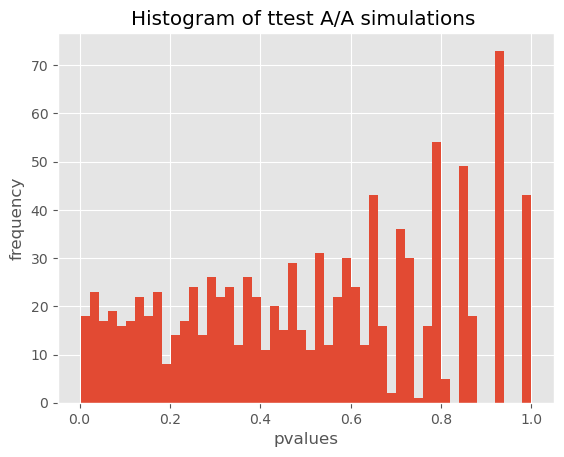

In [25]:
hw_fitrd = hw[(hw['version']!='v2.8.0')]
res = metric_fpr(hw_fitrd[( hw_fitrd['experimentVariant']==0)],  hw_fitrd[( hw_fitrd['experimentVariant']==1)], metric_col = metric, n_sim = 1000, n_s_perc = n_s_perc, n_s_min = n_s_min, estimator = 'prop')
print ('FPR = {}'.format (res['fpr']['fpr_95']))

plt.hist(res['aa']['pvalue'], bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [ ]:
Распределение pvalue более менее равномерное (в данном случае повлиял тип и особенность оценщика, на то что не очень получилось равномерно)

# Вариант 2 решения задачи (домашка студента, просто проведен АА тест используя пример из лекции 3 )

In [26]:
data = pd.read_csv('hw_aa.csv', sep = ';')
data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


  0%|          | 0/1000 [00:00<?, ?it/s]

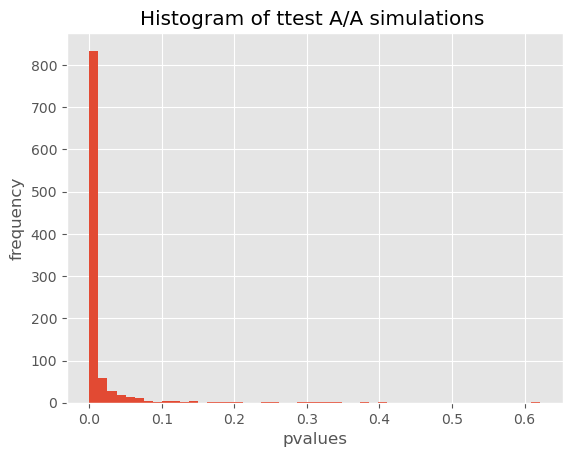

0.938

In [27]:
#p-value должен получиться меньше 0.05
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[(data['experimentVariant'] == 1)]['purchase'].sample(n_s, replace = False).values
    s2 = data[(data['experimentVariant'] == 0)]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [32]:
#посмотрим на среднее в разрезе версий
data.groupby(['version']).agg({'purchase':'mean'})

,purchase
version,
v2.8.0,0.023372
v2.9.0,0.072973
v3.7.4.0,0.061484
v3.8.0.0,0.060319


In [33]:
#проверим распределение каждой из групп
print(stats.shapiro(data[data['version'] == 'v2.8.0']['purchase'].sample(1000, random_state=17)))
print(stats.shapiro(data[data['version'] == 'v2.9.0']['purchase'].sample(1000, random_state=17)))
print(stats.shapiro(data[data['version'] == 'v3.7.4.0']['purchase'].sample(1000, random_state=17)))
print(stats.shapiro(data[data['version'] == 'v3.8.0.0']['purchase'].sample(1000, random_state=17)))


ShapiroResult(statistic=0.12385976314544678, pvalue=0.0)
ShapiroResult(statistic=0.27437031269073486, pvalue=0.0)
ShapiroResult(statistic=0.24883735179901123, pvalue=0.0)
ShapiroResult(statistic=0.2541196942329407, pvalue=0.0)


In [ ]:
Тест Шапиро-Уилка является тестом на нормальность. 
Он используется для определения того, соответствует ли выборка нормальному распределению .

Этот тип теста полезен для определения того, исходит ли данный набор данных из нормального распределения,
что является распространенным предположением, используемым во многих статистических тестах, включая регрессию, 
дисперсионный анализ , t-тесты и многие другие.

# Примеры из леции 2 по АА тестам

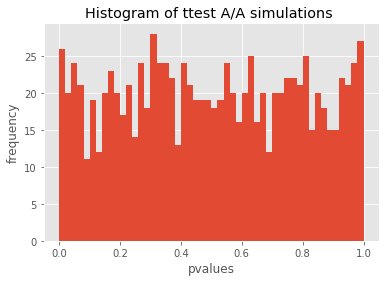

0.056

In [52]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Второй случай, когда A/A-тест не сходится

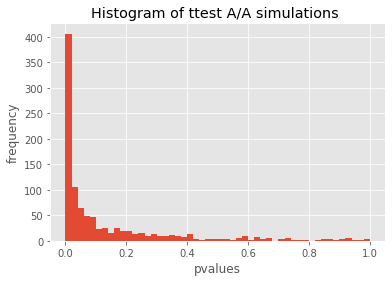

0.541

In [51]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n) * 1.1 # добавляем эффект 10%
})

for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations